In [23]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [24]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../data/data-cluster-examples-dont-pause"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    # if "fallingDrop" not in directory:
    #     print(f"Skipping {directory}")
    #     continue

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        # assert len(corresponding_liveInfo) == len(
        #     tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        # tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

        # describe data
        # print(f"Time: {time}")
        # print(corresponding_liveInfo["avgParticlesPerCell"].describe())
        # print("")

Processing ../../data/data-cluster-examples-dont-pause/falling_drop_2
Processing ../../data/data-cluster-examples-dont-pause/falling_drop_1
Processing ../../data/data-cluster-examples-dont-pause/exploding_liquid_2
Processing ../../data/data-cluster-examples-dont-pause/exploding_liquid_1
Processing ../../data/data-cluster-examples-dont-pause/spinodal_decomp_2
Processing ../../data/data-cluster-examples-dont-pause/spinodal_decomp_equilibration_1
Processing ../../data/data-cluster-examples-dont-pause/spinodal_decomp_equilibration_2
Processing ../../data/data-cluster-examples-dont-pause/spinodal_decomp_1


In [25]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(46430, 30)

In [26]:
df.describe()

avgParticlesPerCell        cutoff   domainSizeX   domainSizeY  \
count         4.643000e+04  46430.000000  46430.000000  46430.000000   
mean          1.800276e+14      2.612643     42.908000     41.923722   
std           1.302795e+15      0.337734     11.422805     10.486611   
min           3.958300e-02      2.000000     15.000000     29.561231   
25%           2.194635e+00      2.500000     45.750000     29.561231   
50%           2.577781e+00      2.500000     46.250000     45.750000   
75%           6.829864e+00      3.000000     49.561231     46.250000   
max           9.607679e+15      3.000000     49.561231     60.000000   

        domainSizeZ  estimatedNumNeighborInteractions   homogeneity  \
count  46430.000000                      4.643000e+04  46430.000000   
mean      38.417177                      4.916827e+05      0.283141   
std       10.277960                      2.721216e+05      0.125933   
min       15.000000                      1.338300e+04      0.080979   
25%       37.296003                      2.796540e+05      0.187408   
50%       37.296003                      5.430290e+05      0.306223   
75%       45.750000                      7.548960e+05      0.409203   
max       46.250000                      1.122188e+06      0.536758   

         maxDensity  maxParticlesPerCell  minParticlesPerCell  ...  \
count  46430.000000         46430.000000              46430.0  ...   
mean       1.070926            23.283244                  0.0  ...   
std        0.337814            13.041312                  0.0  ...   
min        0.463957             7.000000                  0.0  ...   
25%        0.772866            12.000000                  0.0  ...   
50%        1.088394            18.000000                  0.0  ...   
75%        1.354086            38.000000                  0.0  ...   
max        2.044946            54.000000                  0.0  ...   

       particleSize  particleSizeNeededByFunctor  \
count       46430.0                      46430.0   
mean          128.0                         72.0   
std             0.0                          0.0   
min           128.0                         72.0   
25%           128.0                         72.0   
50%           128.0                         72.0   
75%           128.0                         72.0   
max           128.0                         72.0   

       particlesPerBlurredCellStdDev  particlesPerCellStdDev  \
count                   46430.000000            46430.000000   
mean                        0.306401                0.049776   
std                         0.302579                0.066912   
min                         0.005625                0.006075   
25%                         0.140208                0.022822   
50%                         0.244160                0.033604   
75%                         0.260963                0.035240   
max                         5.331309                1.105479   

       rebuildFrequency          skin   threadCount  CellSizeFactor  \
count      46430.000000  46430.000000  46430.000000         46430.0   
mean          11.525953      1.403791     13.800000             1.0   
std            2.302465      1.093088     10.665948             0.0   
min           10.000000      0.200000      1.000000             1.0   
25%           10.000000      0.500000      4.000000             1.0   
50%           10.000000      1.000000     12.000000             1.0   
75%           15.000000      3.000000     24.000000             1.0   
max           15.000000      3.000000     28.000000             1.0   

            Reduced      Smoothed  
count  4.643000e+04  4.643000e+04  
mean   8.292302e+07  8.011640e+07  
std    9.017730e+07  8.737212e+07  
min    9.973890e+05  9.973890e+05  
25%    2.834012e+07  2.792465e+07  
50%    5.289612e+07  5.189006e+07  
75%    1.097719e+08  1.033263e+08  
max    6.492644e+08  6.492644e+08  

[8 rows x 24 columns]

In [27]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Define Interesting Data to observe


In [28]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [29]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# !!!This is probably bad!!!

I filter the whole data based on wheter it is better than `0.2` of !!all!! other data. This filters out way to much

In [30]:
SPEEDUP_CUT = 0.2


# only keep rows where performance percentage is above x
print("Orignal length", len(df))

# group data on input columns
grouped = df


def add_Speedup_column(group):
    min_smoothed = group['Smoothed'].min()
    result = group.copy()
    result['speedup'] = min_smoothed / result['Smoothed']
    return result


grouped_speedup = add_Speedup_column(grouped)

grouped_speedup.drop(columns=["Smoothed", "Reduced"], inplace=True)


# only keep rows where best_smoothed/current_smoothed is above 0.7
filtered_groups = grouped_speedup.groupby(inputs).filter(
    lambda x: x['speedup'].max() > SPEEDUP_CUT)


print("Filtered length", len(filtered_groups))


def unique_string_elems(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# Combine all string columns into unique values
combined = filtered_groups.groupby(inputs).agg(
    unique_string_elems).reset_index()

print("Combined length", len(combined))

Orignal length 46430
Filtered length 3295
Combined length 2393


/tmp/ipykernel_251362/2903725433.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(16, 5))


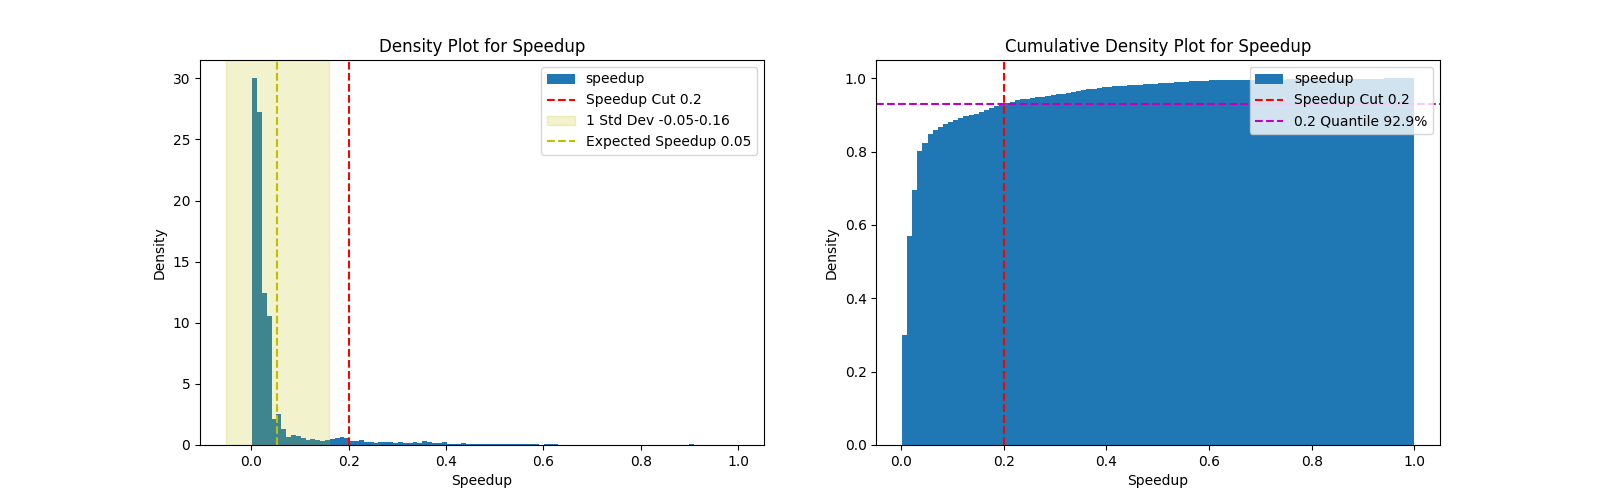

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# relative performance
grouped_speedup["speedup"].plot.hist(
    bins=100, ax=ax[0], density=True)
ax[0].set_title("Density Plot for Speedup")
ax[0].set_xlabel("Speedup")
ax[0].set_ylabel("Density")
ax[0].axvline(x=SPEEDUP_CUT, color='r',
              linestyle='--', label=f"Speedup Cut {SPEEDUP_CUT}")

expectation = grouped_speedup["speedup"].mean()
std_dev = grouped_speedup["speedup"].std()

ax[0].axvspan(expectation-std_dev, expectation+std_dev, color='y', alpha=0.2,
              label=f"1 Std Dev {np.round(expectation-std_dev, 2)}-{np.round(expectation+std_dev, 2)}")

ax[0].axvline(x=expectation, color='y', linestyle='--',
              label=f"Expected Speedup {np.round(expectation, 2)}")

ax[0].legend(loc='upper right')

# cummulative distribution
grouped_speedup["speedup"].plot.hist(
    bins=100, ax=ax[1], density=True, cumulative=True)
ax[1].set_title("Cumulative Density Plot for Speedup")
ax[1].set_xlabel("Speedup")
ax[1].set_ylabel("Density")
ax[1].axvline(x=SPEEDUP_CUT, color='r',
              linestyle='--', label=f"Speedup Cut {np.round(SPEEDUP_CUT, 2)}")

value_at_top_performance = 1-len(filtered_groups) / len(df)

ax[1].axhline(y=value_at_top_performance, color='m',
              linestyle='--', label=f"{SPEEDUP_CUT} Quantile {np.round(100*value_at_top_performance, 2)}%")
ax[1].legend(loc='upper right')

# Filter Data / Outliers

In [32]:
Z_THRESHHOLD = 3
for column in inputs:
    z = np.abs(stats.zscore(combined[column]))
    combined = combined[z < Z_THRESHHOLD]

print("Outliers removed length", len(combined))


# filter values occuring less than pct
SPARSE_CUTOFF = 0.01
for column in outputs:
    counts = combined[column].value_counts()

    sparse_values = combined[column].isin(
        counts[counts > len(combined) * SPARSE_CUTOFF].index)

    combined = combined[sparse_values]


print("Sparse values removed length", len(combined))

X, y = combined[inputs], combined[outputs]
print(X.shape, y.shape)

Outliers removed length 2309
Sparse values removed length 2265
(2265, 6) (2265, 3)


# Create Train and Test Data


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [34]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
331          1.614580e-01     0.221708    0.854507                   10   
2260         9.607679e+15     0.271851    1.145468                   10   
1979         9.607679e+15     0.241608    0.966555                    8   
443          1.640620e-01     0.202822    0.786625                    9   
389          1.630210e-01     0.215457    0.835789                    9   

      particlesPerCellStdDev  threadCount  Container_DataLayout  \
331                 0.273600           24  VerletListsCells_AoS   
2260                0.022822           12       LinkedCells_SoA   
1979                0.022822            4  VerletListsCells_SoA   
443                 0.268753           12       LinkedCells_SoA   
389                 0.270854            4       LinkedCells_AoS   

                Traversal  Newton 3  
331   vlc_sliced_balanced  disabled  
2260   lc_sliced_balanced  disabled  
1979  vlc_sliced_balanced   enabled  
443                lc_c04  disabled  
389             lc_sliced   enabled

In [35]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

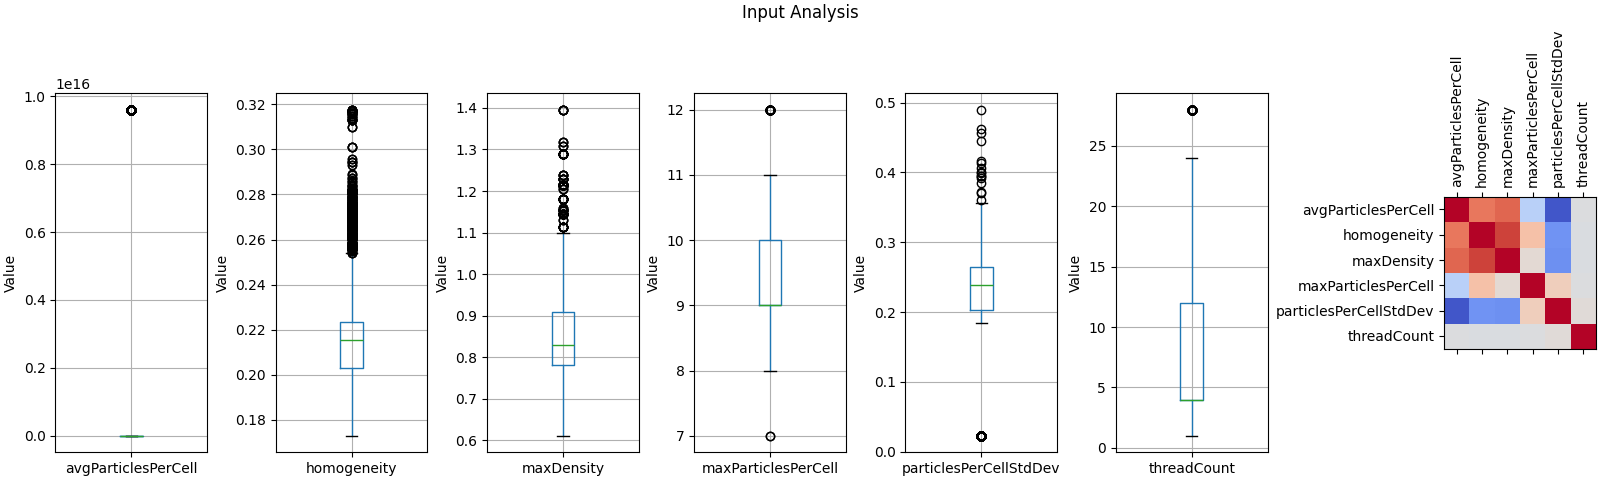

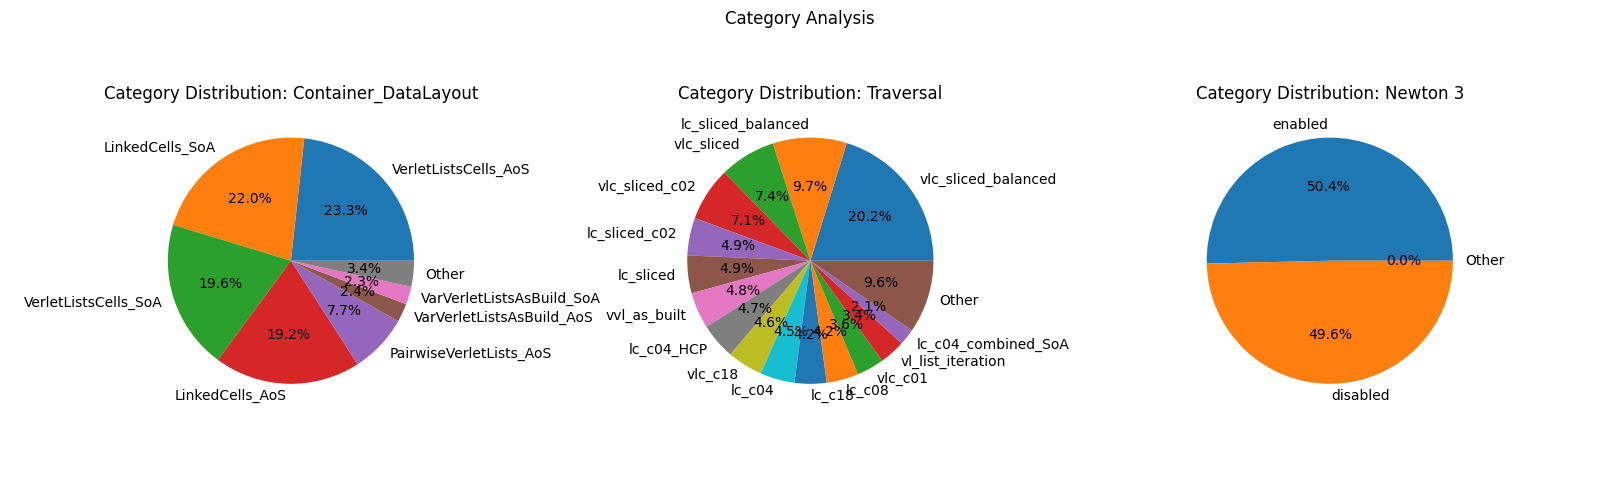

In [36]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [37]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.05,
    "Traversal": 0.05,
    "Newton 3": 0.05,

}

# maximum depth of the decision tree
MAX_DEPTH = 5

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 2

Training on 1812 samples
Number of rules 32:
	Container_DataLayout (10 rules)
	Traversal (21 rules)
	Newton 3 (1 rules)


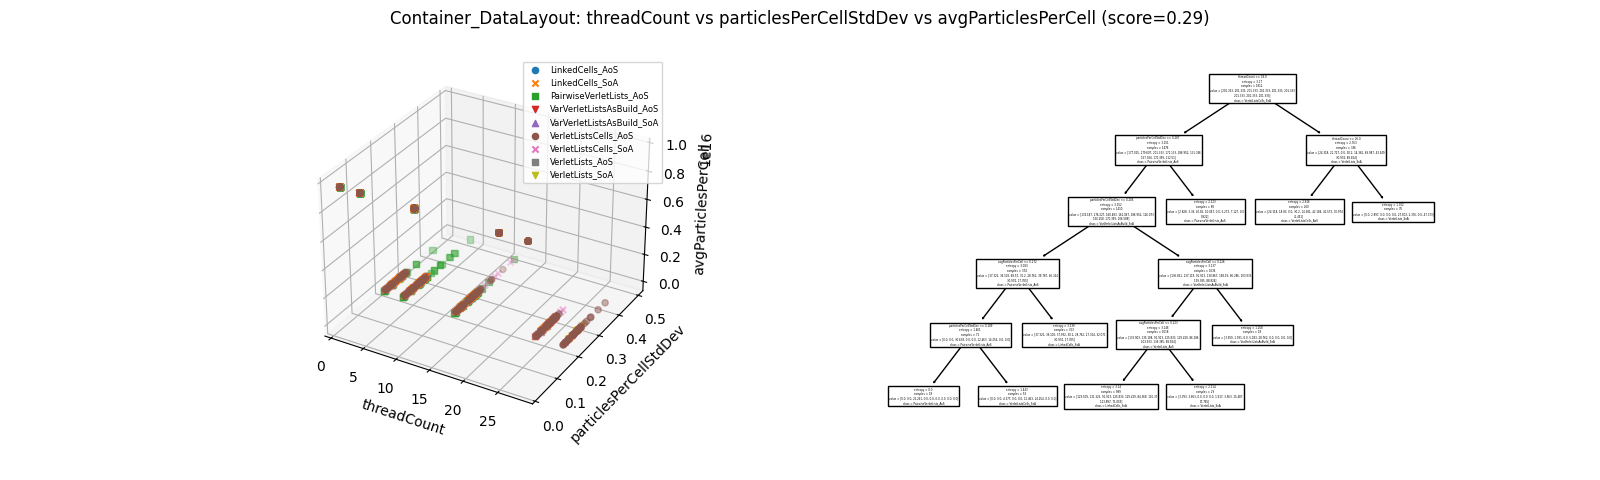

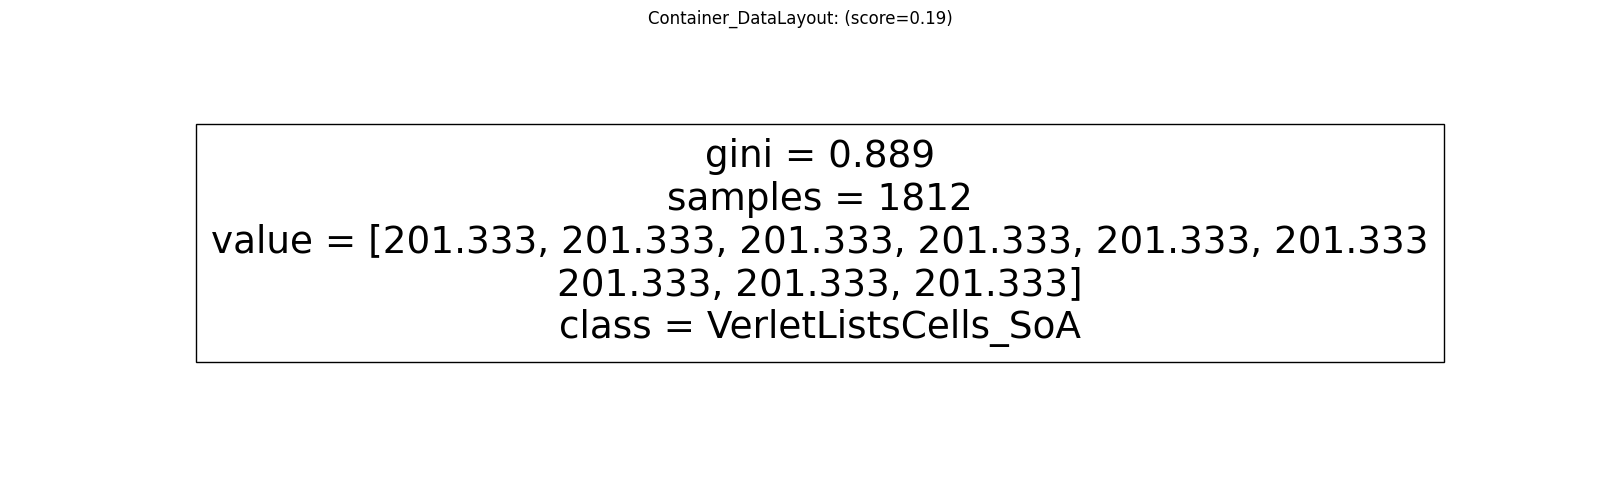

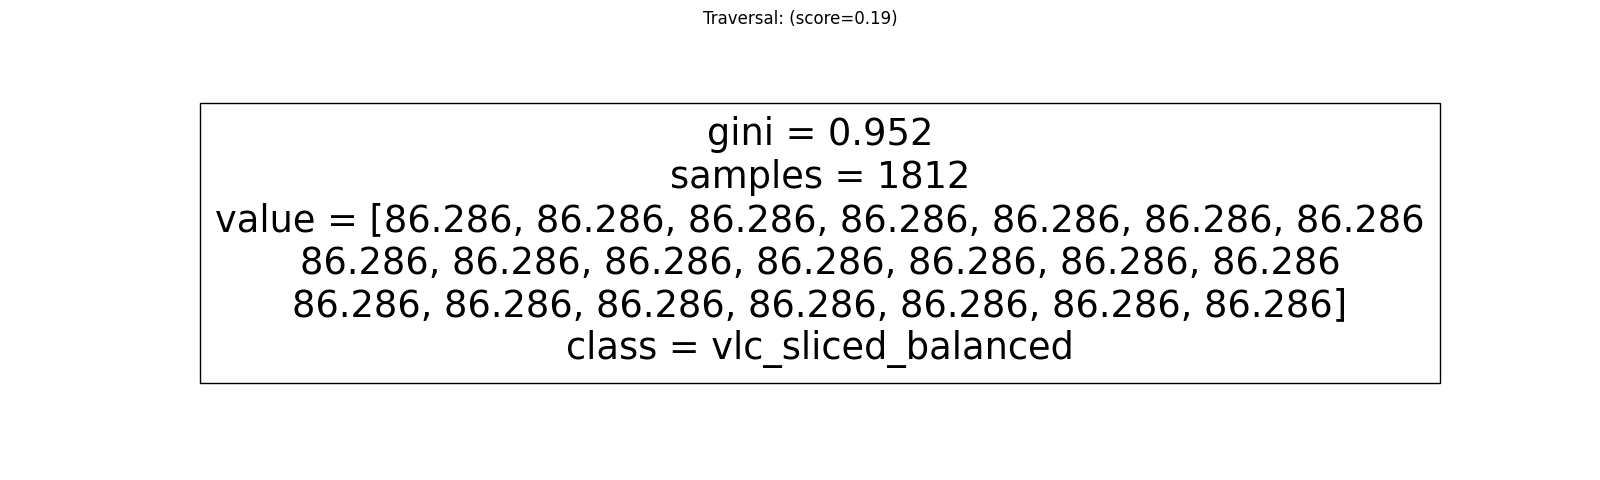

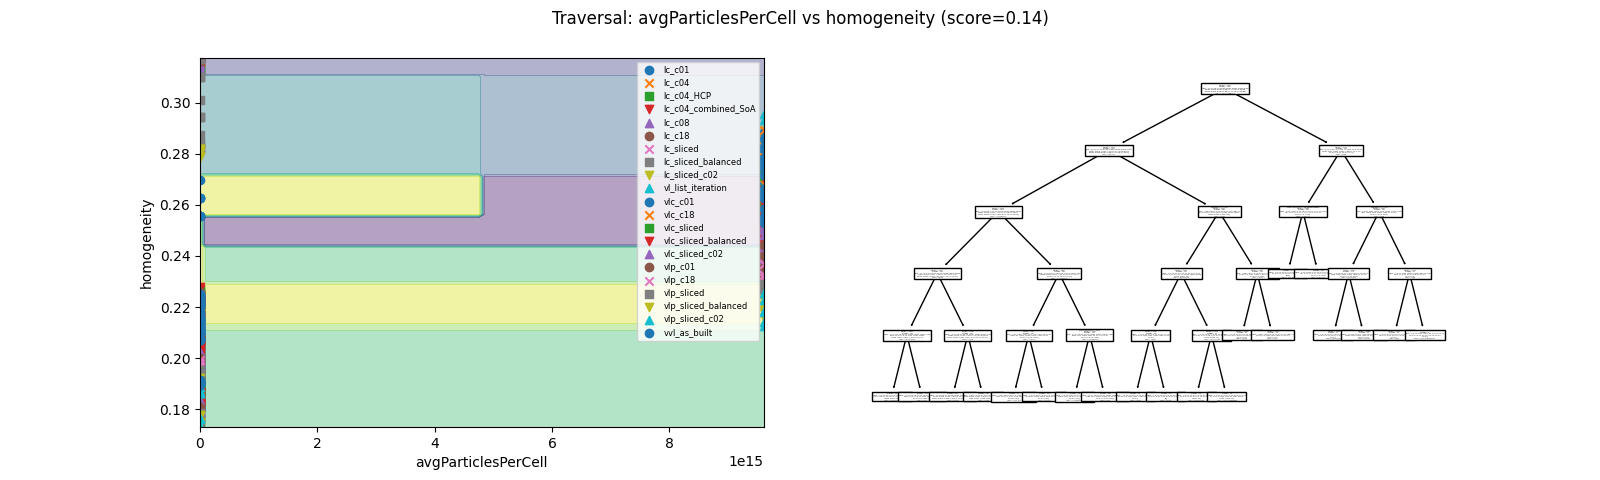

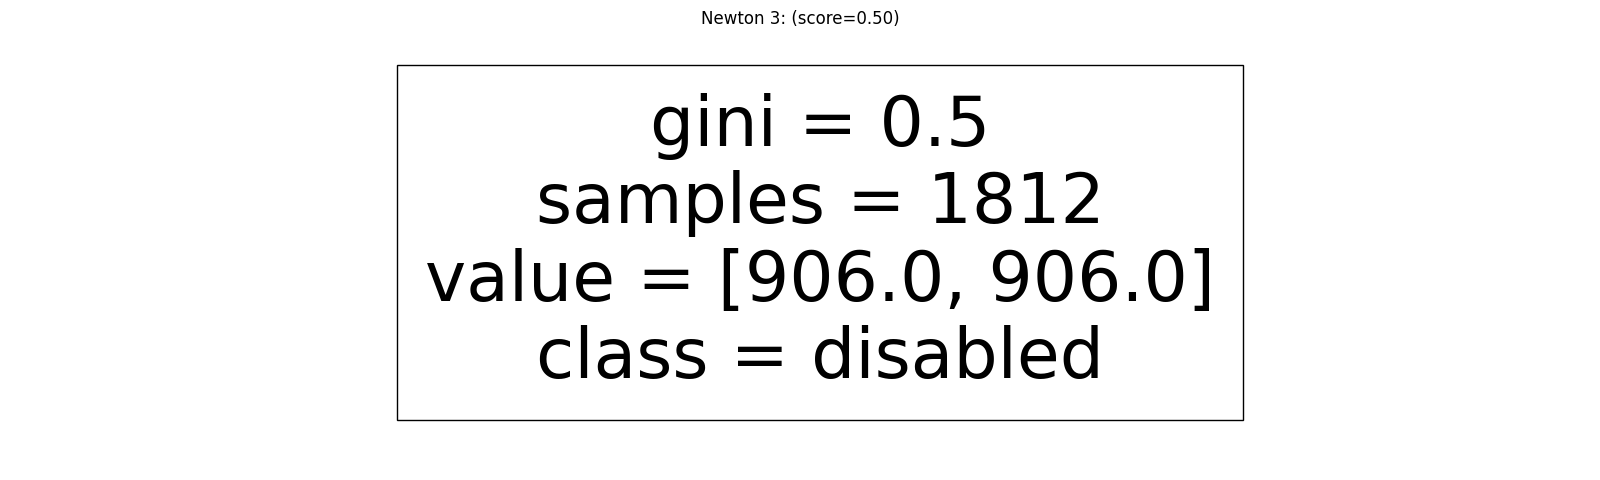

In [38]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

threadCount: [-inf, 18.0, 26.0, inf]
threadCount: [-inf, 18.0, 26.0, inf]

particlesPerCellStdDev: [-inf, 0.189, 0.205, 0.287, inf]
particlesPerCellStdDev: [-inf, 0.189, 0.205, 0.287, inf]

avgParticlesPerCell: [-inf, 0.161, 0.17, 0.171, 0.175, 0.179, 0.223, 0.226, 0.228, 0.233, 0.272, 0.309, 4803839853068288.0, inf]
avgParticlesPerCell: [-inf, 0.161, 4803839853068288.0, inf]

homogeneity: [-inf, 0.187, 0.212, 0.213, 0.219, 0.229, 0.244, 0.255, 0.271, 0.312, inf]
homogeneity: [-inf, 0.187, 0.212, 0.219, 0.229, 0.244, 0.255, 0.271, 0.312, inf]



delta_x = 31040755256955.004, number of points = 2.414247125813956e-28, should be at least 10
delta_x = 31040755256955.004, number of points = 0.0, should be at least 10


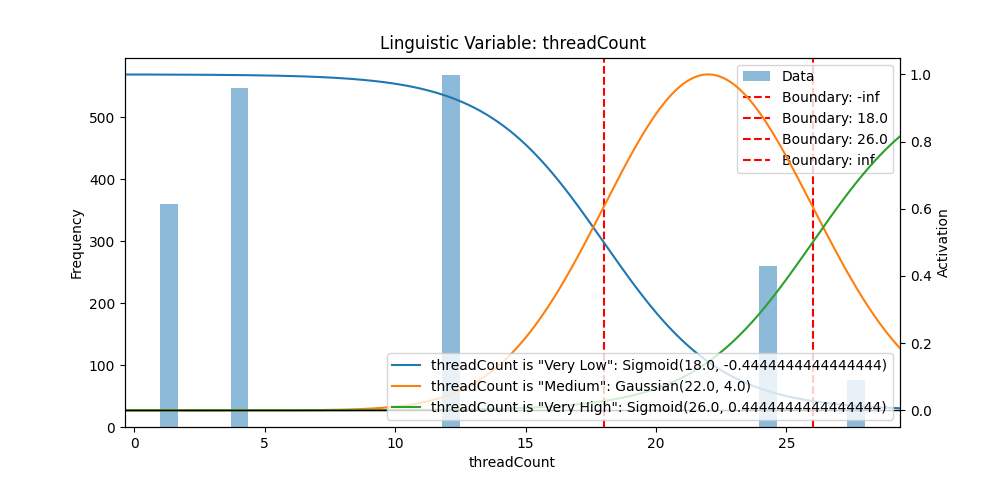

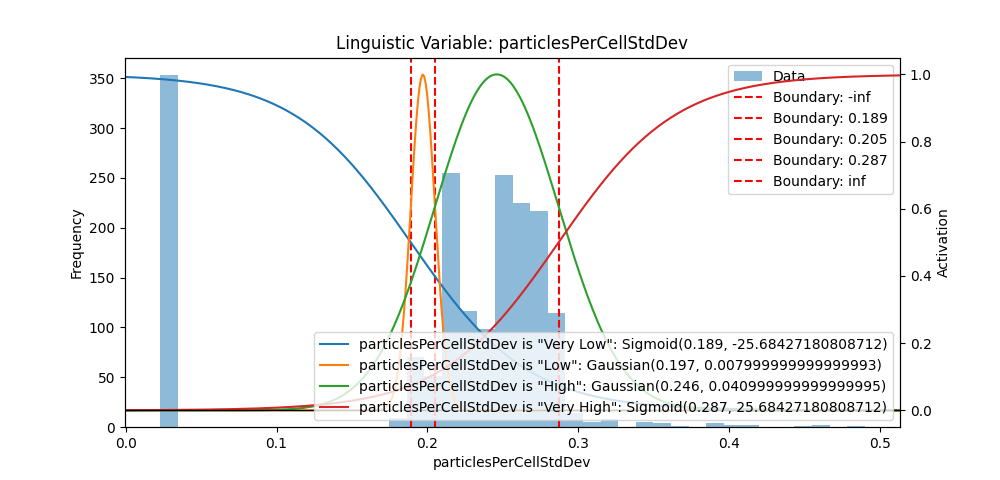

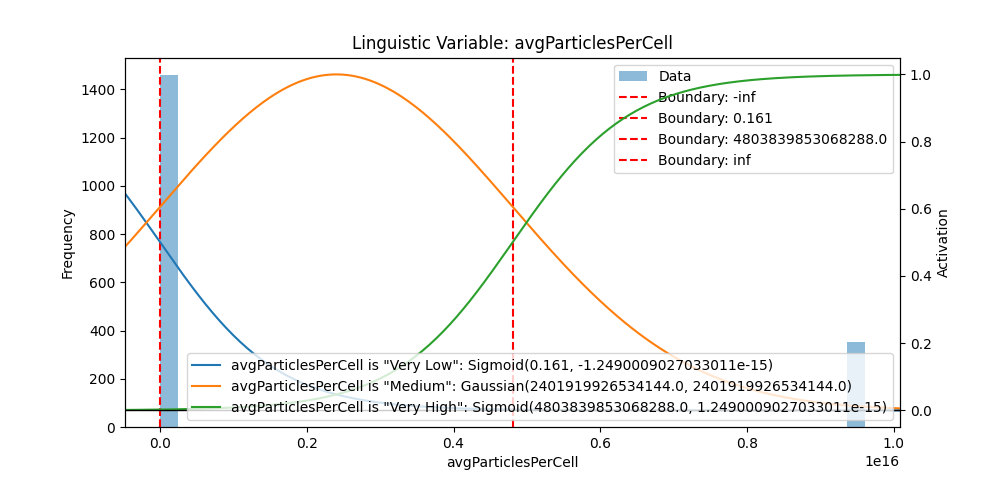

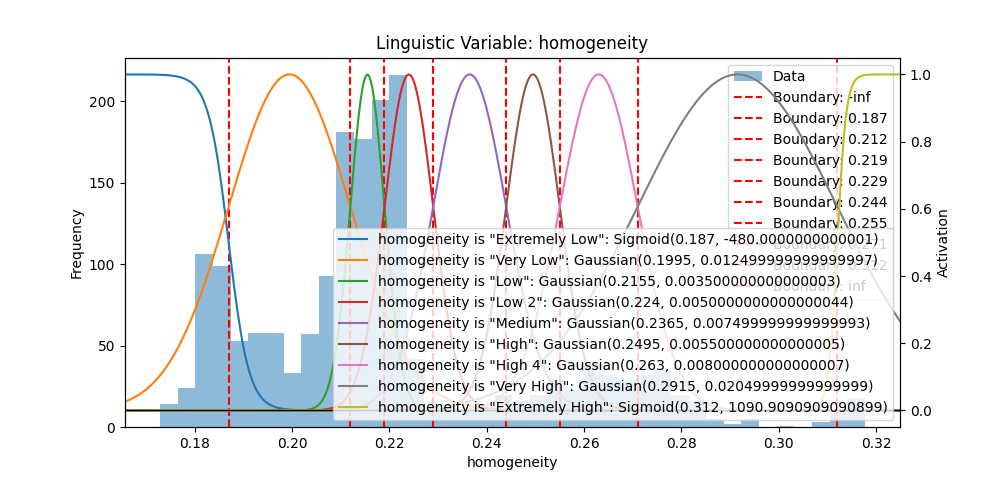

In [39]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


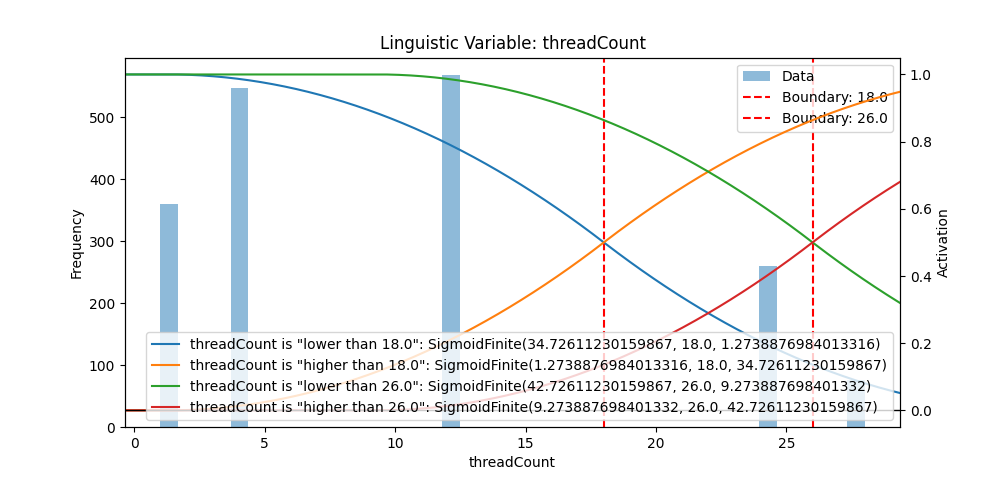

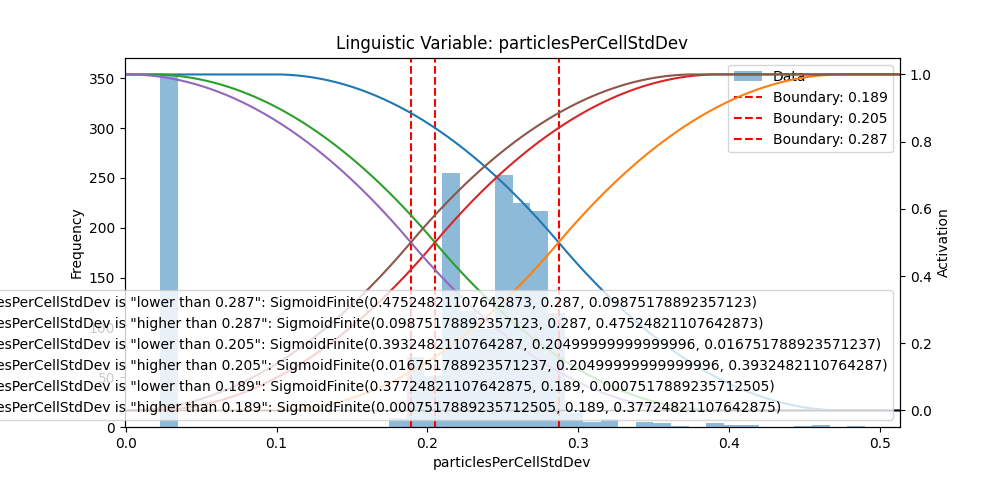

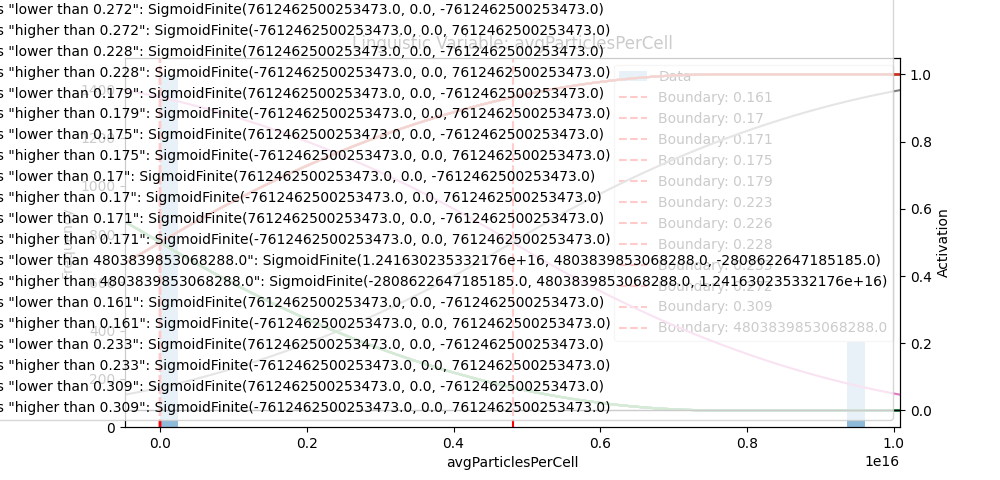

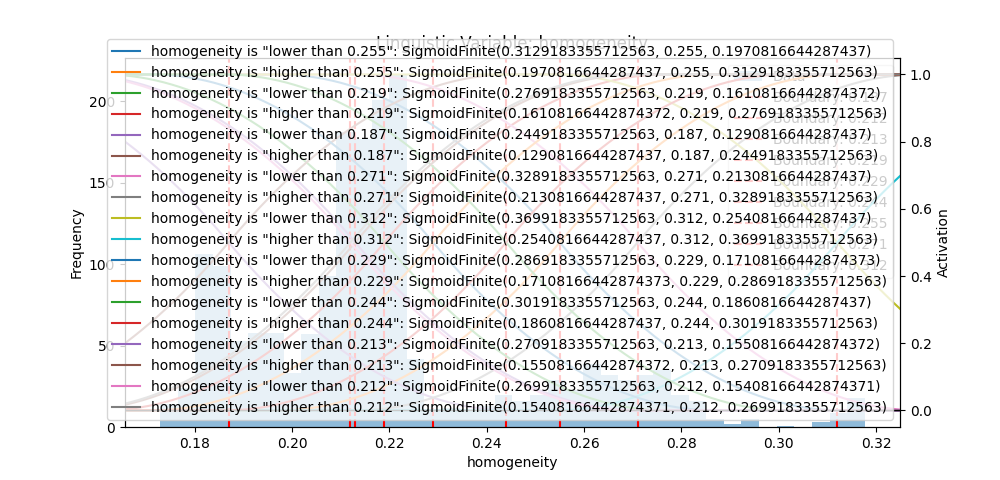

In [40]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

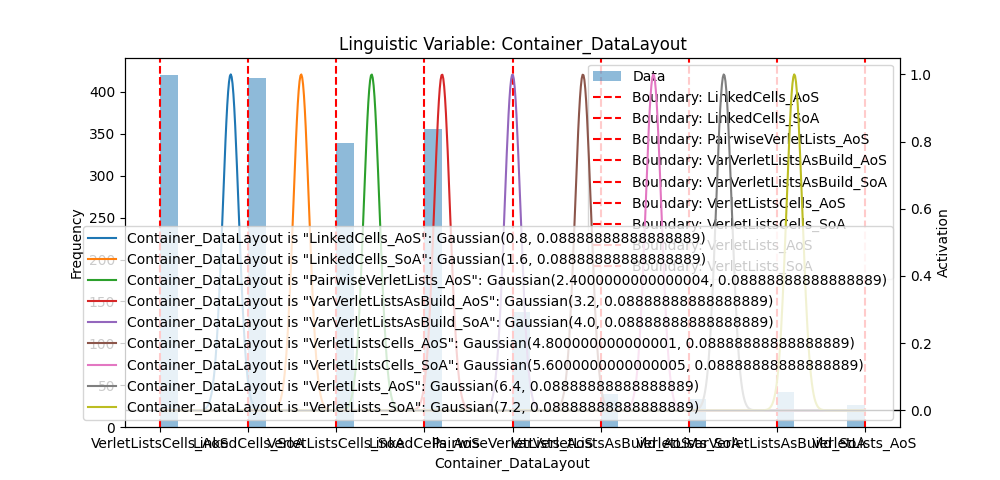

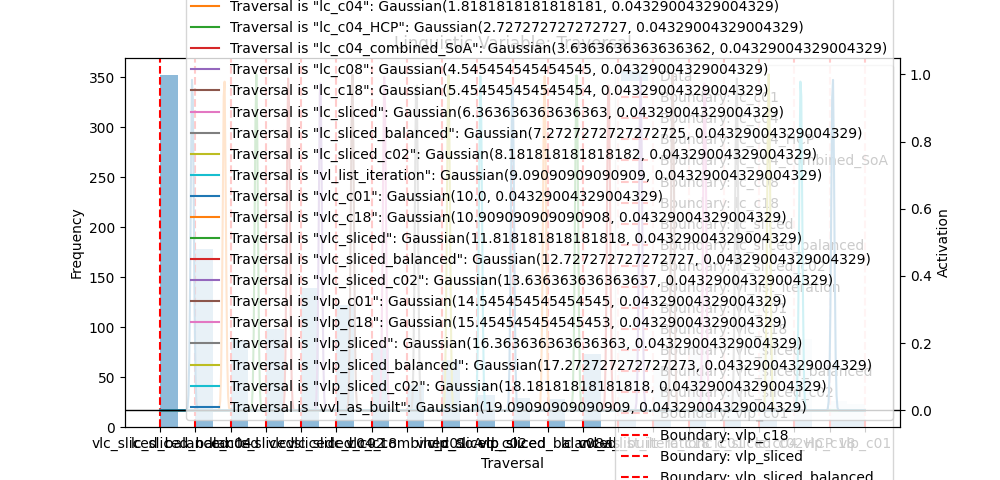

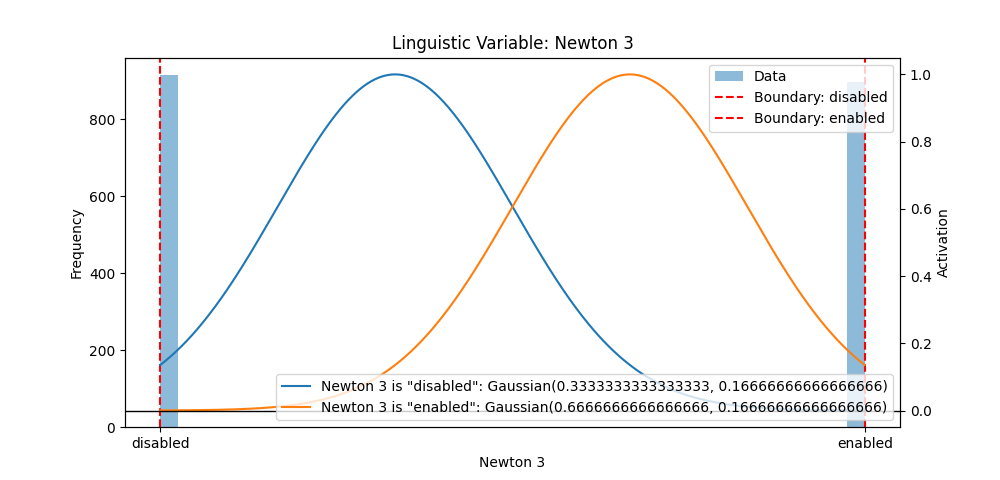

In [41]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [42]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "threadCount" range: (-15.726112301598668, 44.72611230159867)
	"Very Low": Sigmoid(18.0, -0.4444444444444444)
	"Medium": Gaussian(22.0, 4.0)
	"Very High": Sigmoid(26.0, 0.4444444444444444)

FuzzyVariable: domain: "particlesPerCellStdDev" range: (-0.16542621107642874, 0.6782822110764288)
	"Very Low": Sigmoid(0.189, -25.68427180808712)
	"Low": Gaussian(0.197, 0.007999999999999993)
	"High": Gaussian(0.246, 0.040999999999999995)
	"Very High": Sigmoid(0.287, 25.68427180808712)

FuzzyVariable: domain: "avgParticlesPerCell" range: (-7612462500253473.0, 1.7220141705310532e+16)
	"Very Low": Sigmoid(0.161, -1.2490009027033011e-15)
	"Medium": Gaussian(2401919926534144.0, 2401919926534144.0)
	"Very High": Sigmoid(4803839853068288.0, 1.2490009027033011e-15)

FuzzyVariable: domain: "homogeneity" range: (0.1150286644287437, 0.3755603355712563)
	"Extremely Low": Sigmoid(0.187, -480.0000000000001)
	"Very Low": Gaussian(0.1995, 0.012499999999999997)
	"Low": Gaussian(0.2155, 0.0035